In [1]:
# Import basic packages
import numpy  as np
import pandas as pd
# Import data processing package
from DataProcessing import *
# Import plotting packages
import gspplot
from gspplot import *
import matplotlib as mpl
import matplotlib.pyplot as plt
# Import graph packages
import gsp
from gsp import *
from pygsp import graphs, filters, plotting
# Import other packages
from Learning import *
import warnings;warnings.filterwarnings('ignore')

# 1  Data Processing

## 1.1 Read Data and  Crop a Patch

In [2]:
path_cloud = 'data/Vaihingen3D_Traininig.pts'
# Load dataset as pandas dataframe
cloud      = load_cloud(path_cloud)
newcloud   = cloud_preprocess(cloud)
# Crop a patch from cloud
patch      = crop_patch(newcloud, (150, 300), (150, 300))

-------------------- Load Data ---------------------
Data Loading...
=> Done.
----------------------------------------------------
--------------- Data Pre-Processing ----------------
Drop duplicates...
=> Duplicates #: 40946, Ratio: 5.43% of the dataset.
Re-center the data...
=> Done.
----------------------------------------------------
-------------------- Crop Patch --------------------
Crop the patch...
=> Crop a patch from: x:[150, 300], y:[150, 300].
=> Points left for patch: 157488.
----------------------------------------------------


## 1.2 Data Visualization

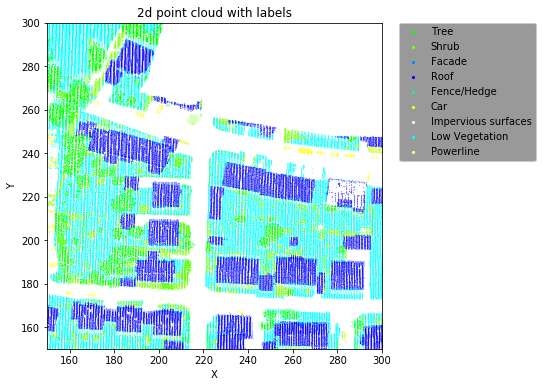

In [3]:
plot_graph_2D(patch, 
              figsize=(6,6), 
              marksize=0.02,
              markerscale=15,
              blackBack=False, 
              xRange=(150, 300), 
              yRange=(150, 300))

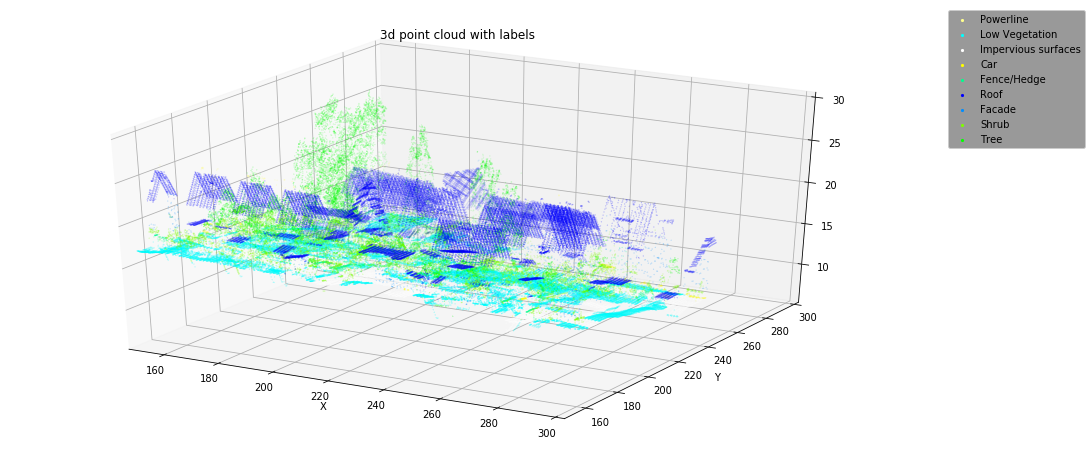

In [4]:
plot_graph_3D(patch, 
              figsize=(16, 8), 
              marksize=0.02, 
              markerscale=15, 
              xRange=(150, 300), 
              yRange=(150, 300))

# 2 Graph Construction 

## 2.1 Use the Number of Neighbors

In [5]:
# 30nn, Gaussian kernel
G_30nn_Gaussain = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=30, dist3D=False, 
                                mode='distance', neightype='number', lap_type='combinatorial')
# 10nn, Gassian kernel
G_10nn_Gaussain = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=10, dist3D=False, 
                                mode='distance', neightype='number', lap_type='combinatorial')
# 30nn, Binary graph
G_30nn_Binary   = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=30, dist3D=False, 
                                mode='connectivity', neightype='number', lap_type='combinatorial')
# 10nn, Binary graph
G_10nn_Binary   = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=10, dist3D=False, 
                                mode='connectivity', neightype='number', lap_type='combinatorial')
# 30nn, Local scaling
G_30nn_Local    = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], k=30, dist3D=False, 
                                mode='local', neightype='number', lap_type='combinatorial')
# 10nn, Local scaling
G_10nn_Local    = gsp.knn_graph(cloud=patch[['x', 'y', 'z']],k=10, dist3D=False, 
                                mode='local', neightype='number', lap_type='combinatorial')

## 2.2 Use the Radius to Find Neighbors

In [6]:
# r3, Gaussian kernel
G_r3_Gaussain  = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], r=3, dist3D=False, 
                               mode='distance', neightype='radius', lap_type='combinatorial')
# r05, Gassian kernel
G_r05_Gaussain = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], r=.5, dist3D=False, 
                               mode='distance', neightype='radius', lap_type='combinatorial')
# r3, Binary graph
G_r3_Binary    = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], r=3, dist3D=False, 
                               mode='connectivity', neightype='radius', lap_type='combinatorial')
# r05, Binary graph
G_r05_Binary   = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], r=.5, dist3D=False, 
                               mode='connectivity', neightype='radius', lap_type='combinatorial')
# r3, Local scaling
G_r3_Local     = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], r=3, dist3D=False, 
                               mode='local', neightype='radius', lap_type='combinatorial')
# r05, Local scaling
G_r05_Local    = gsp.knn_graph(cloud=patch[['x', 'y', 'z']], r=.5, dist3D=False, 
                               mode='local', neightype='radius', lap_type='combinatorial')

# 3 POI Detection

## 3.1 Mexican Hat Filter Construction

In [7]:
# Create graph list
graph_list = [G_30nn_Gaussain, G_10nn_Gaussain, G_30nn_Binary, G_10nn_Binary, 
              G_30nn_Local,    G_10nn_Local,    G_r3_Gaussain, G_r05_Gaussain, 
              G_r3_Binary,     G_r05_Binary,    G_r3_Local,    G_r05_Local]

# Initialize filters dictionary
filter_dict = dict.fromkeys(['g_MH_30nn_Gaussain', 'g_MH_10nn_Gaussain', 'g_MH_30nn_Binary', 
                             'g_MH_10nn_Binary', 'g_MH_30nn_Local', 'g_MH_10nn_Local',
                             'g_MH_r3_Gaussain', 'g_MH_r05_Gaussain', 'g_MH_r3_Binary',
                             'g_MH_r05_Binary', 'g_MH_r3_Local', 'g_MH_r05_Local'])
for i, idx in zip(filter_dict.keys(), range(12)):
    filter_dict[i] = filters.MexicanHat(graph_list[idx], Nf=1+len([0.04]), lpfactor=1, scales=[0.04])

## 3.2 Visualization Filters

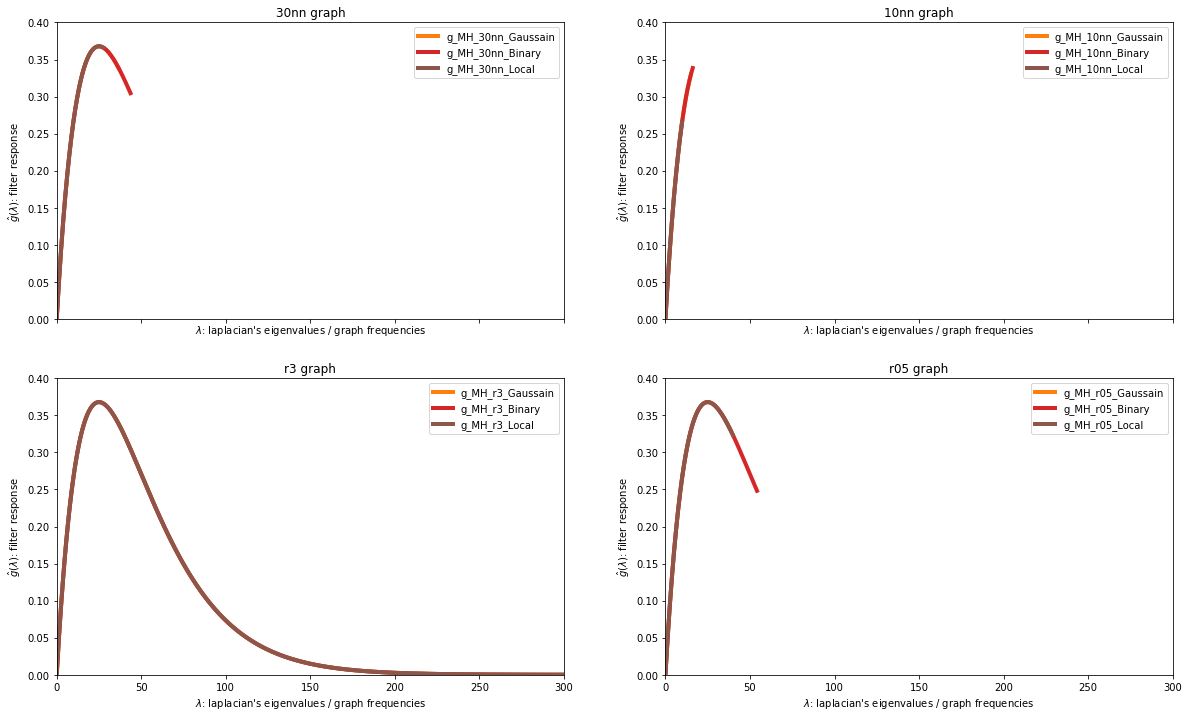

In [8]:
filter_key = ['g_MH_30nn_Gaussain', 'g_MH_30nn_Binary', 'g_MH_30nn_Local',
              'g_MH_10nn_Gaussain', 'g_MH_10nn_Binary', 'g_MH_10nn_Local',
              'g_MH_r3_Gaussain', 'g_MH_r3_Binary', 'g_MH_r3_Local',
              'g_MH_r05_Gaussain', 'g_MH_r05_Binary', 'g_MH_r05_Local']
title_list = ['30nn graph', '10nn graph', 'r3 graph', 'r05 graph']
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True)
for j in range(4):
    ax = axes[int(j>1), j%2]
    legend_list2 = []
    for i in range(3):
        filter_dict[filter_key[j*3+i]].plot(ax=ax, show_sum=False)
        ax.lines.pop(i)
        legend_list2.append(filter_key[j*3+i])
    ax.set_title(title_list[j])
    ax.legend(legend_list2)
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 0.4)

## 3.3 POI Detection and Visualization

In [9]:
thresh_mex_hat = 0.2
# Create signal dictionary
signal_dict = dict.fromkeys(['s_30nn_Gaussain', 's_10nn_Gaussain', 's_30nn_Binary', 
                             's_10nn_Binary',   's_30nn_Local',    's_10nn_Local',
                             's_r3_Gaussain',   's_r05_Gaussain',  's_r3_Binary',
                             's_r05_Binary',    's_r3_Local',      's_r05_Local'])

# Create edge dictonary, highlight nodes that have high frequency
edge_dict = dict.fromkeys(['edgeind_30nn_Gaussain', 'edgeind_10nn_Gaussain', 'edgeind_30nn_Binary', 
                           'edgeind_10nn_Binary',   'edgeind_30nn_Local',    'edgeind_10nn_Local',
                           'edgeind_r3_Gaussain',   'edgeind_r05_Gaussain',  'edgeind_r3_Binary',
                           'edgeind_r05_Binary',    'edgeind_r3_Local',      'edgeind_r05_Local'])

for i, j, k in zip(signal_dict.keys(), filter_dict.keys(), edge_dict.keys()):
    signal_dict[i] = filter_dict[j].filter(patch.z, method = 'chebyshev')
    edge_dict[k]   = signal_dict[i][:, -1] >= thresh_mex_hat

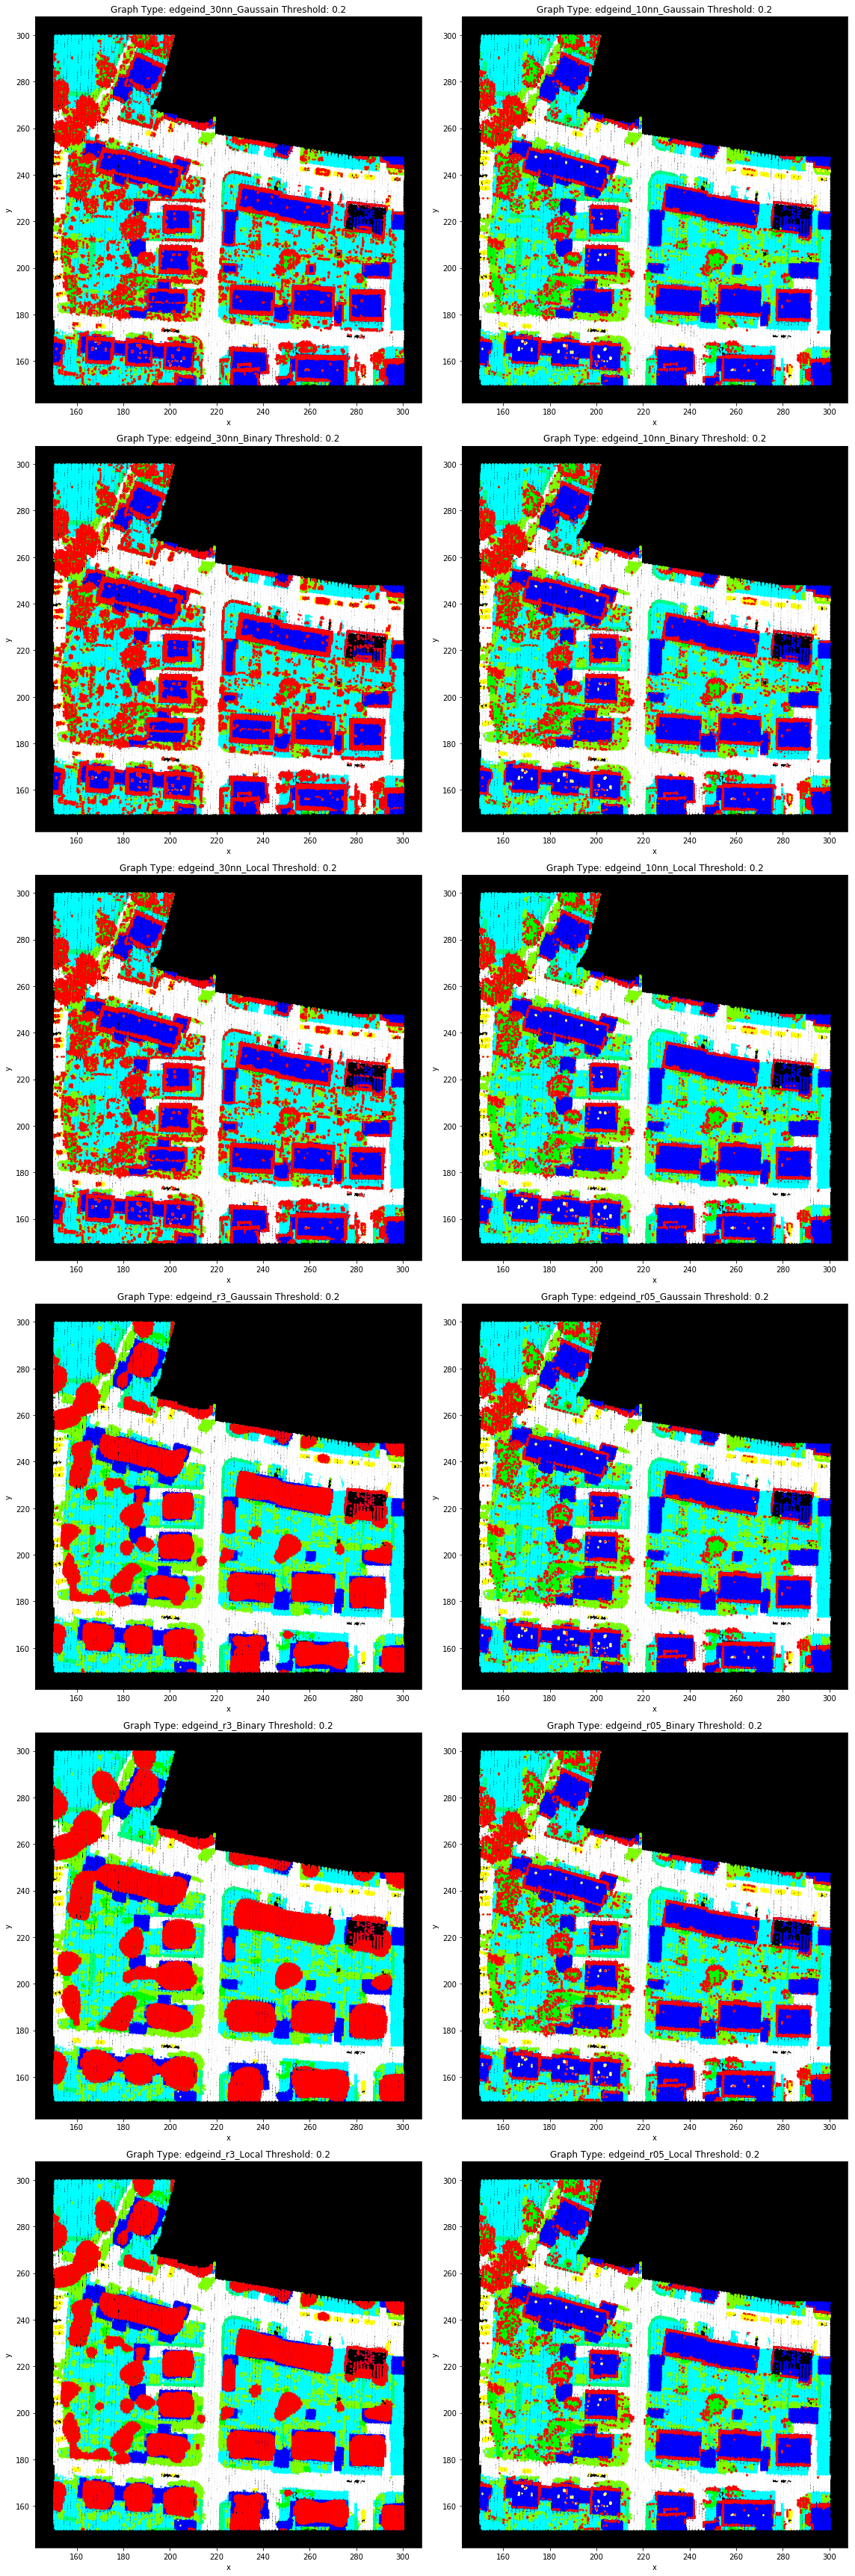

In [10]:
# Plot results
fig, axes = plt.subplots(6, 2, figsize=(16, 48))
for i, j in zip(edge_dict.keys(), range(12)):              
    gspplot.plot_vaihingen_2D(patch, 
                              id_highlight=np.nonzero(edge_dict[i])[0], 
                              ax=axes[j//2, j%2], 
                              label_high='Edges',
                              title="Graph Type: {} Threshold: {}".format(i, thresh_mex_hat))
plt.tight_layout()
plt.show()

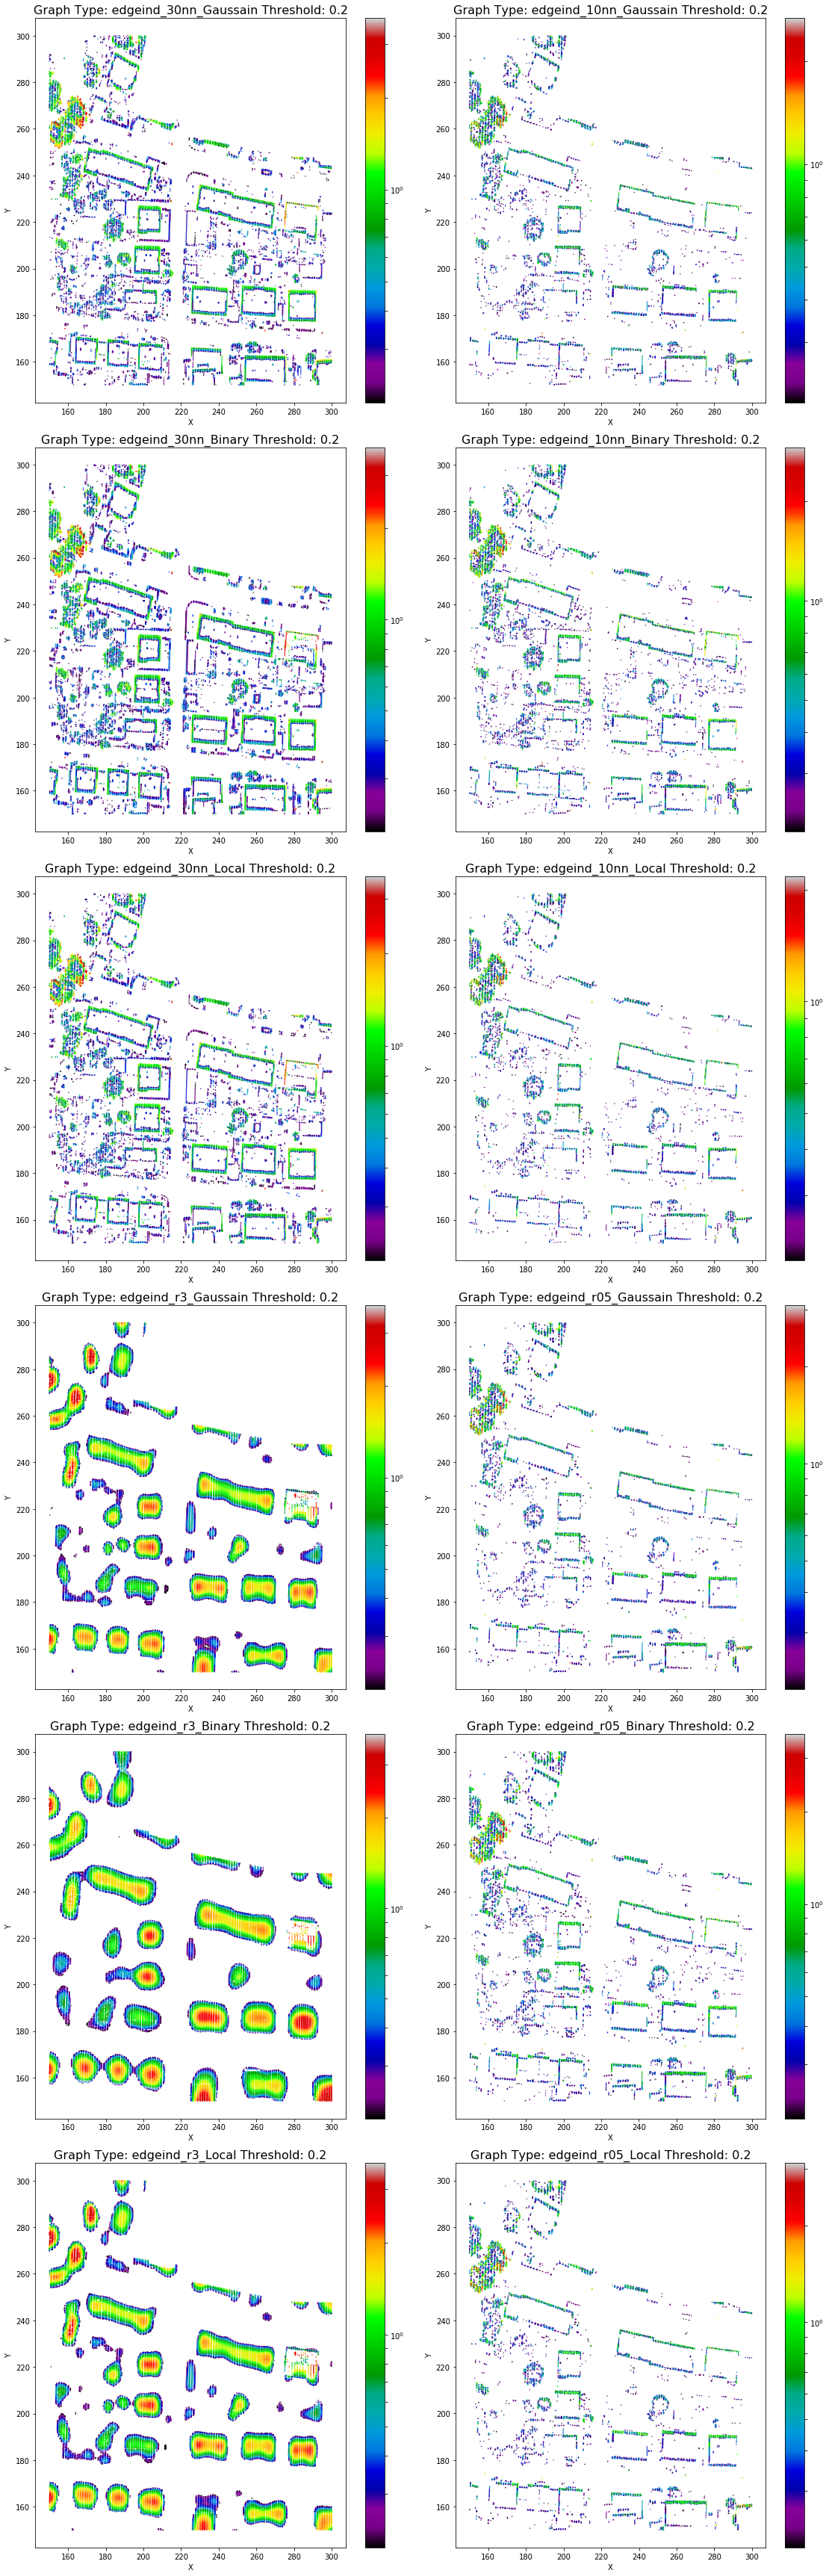

In [11]:
# Plot colormap results
fig, axes = plt.subplots(6, 2, figsize=(16, 48))
for i, j, k in zip(edge_dict.keys(), range(12), signal_dict.keys()):   
    mask = edge_dict[i]
    plot_graph_2D(patch=patch.copy(), 
                  signal=signal_dict[k][:,-1][mask], 
                  ax=axes[j//2, j%2], 
                  mask=mask, 
                  mode='signal_cmp', 
                  title="Graph Type: {} Threshold: {}".format(i, thresh_mex_hat))
plt.tight_layout()
plt.show()

As shown, choosing a larger number of neighbors or searching neighbors in a wider scope is a good way to cure the unbalanced point density distribution. When the number or the scope is small, the binary graph ourperforms the other two types of graph. It is amazing that if we use the radius to detect neighbors, we can not only detect building bodies instead of building bodies. From colormap results, we can not only see the points of interest, but also the intensity of the filtered signal. 

## 3.4 Setting Ground Truth

I use the 30nn Binary graph to prepare for the ground truth. The signal value of the building nodes is 1, while that of other nodes is 0.

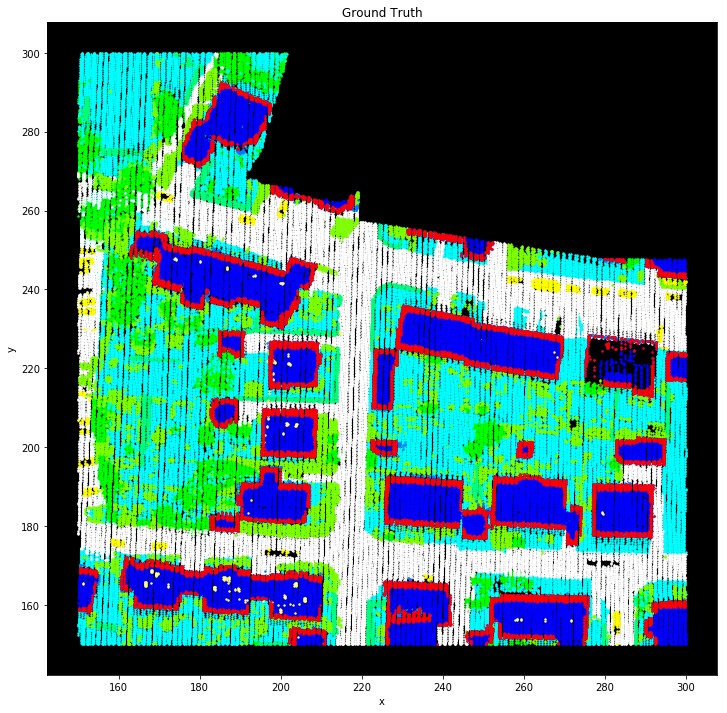

In [12]:
#df2 is the original 'patch' dataframe plus two columns 'is_building' and 'is_edge'
#edge_roof indicates roof edge points
df2, edge_roof = set_ground_truth(patch=patch, threshold=0.08, f=filter_dict['g_MH_30nn_Binary'], figsize=(12, 12))


## 3.5 Graph Quantitative Comparison

The table below shows what the highligted points are composed of in each type of the graph.

In [13]:
df = comp_df(patch, edge_dict, labels=labels, normalize=True)
df

Powerline  Low Vegetation  Impervious surfaces       Car  \
30nn_Gaussain   0.007153        0.013928             0.001476  0.012225   
10nn_Gaussain   0.005340        0.002875             0.000575  0.001643   
30nn_Binary     0.006137        0.017379             0.001580  0.020296   
10nn_Binary     0.005317        0.005001             0.001393  0.004558   
30nn_Local      0.006905        0.015307             0.001607  0.016549   
10nn_Local      0.005552        0.002644             0.000705  0.001939   
r3_Gaussain     0.004226        0.041822             0.012480  0.002810   
r05_Gaussain    0.004852        0.002960             0.000247  0.001151   
r3_Binary       0.003859        0.088209             0.024972  0.001253   
r05_Binary      0.004815        0.004485             0.000660  0.002968   
r3_Local        0.004188        0.047517             0.013376  0.002653   
r05_Local       0.004901        0.003133             0.000321  0.001366   

               Fence/Hedge      Roof    Facade     Shrub      Tree  
30nn_Gaussain     0.040952  0.413724  0.013588  0.141819  0.355134  
10nn_Gaussain     0.009365  0.441797  0.028834  0.059065  0.450505  
30nn_Binary       0.051773  0.425880  0.011059  0.146234  0.319661  
10nn_Binary       0.014243  0.417168  0.025258  0.096601  0.430461  
30nn_Local        0.042670  0.407957  0.013919  0.146787  0.348299  
10nn_Local        0.006698  0.439588  0.030140  0.058870  0.453864  
r3_Gaussain       0.007346  0.623650  0.025115  0.043990  0.238560  
r05_Gaussain      0.011594  0.451772  0.026889  0.053367  0.447167  
r3_Binary         0.001596  0.595967  0.036649  0.047600  0.199895  
r05_Binary        0.015302  0.431634  0.022690  0.080733  0.436713  
r3_Local          0.006666  0.621138  0.026927  0.043833  0.233702  
r05_Local         0.011730  0.449747  0.026432  0.056479  0.445891

This tabel concatenate another four columns. 'Total' logs the total number of red points. 'Total_roof' logs the number of detected roof points. 'Total_edge' logs the number of detected roof edge points. 'Ratio_roof' logs the recall rate of roof points.

In [16]:
sum_df(patch, df, edge_dict, df2)

Powerline  Low Vegetation  Impervious surfaces       Car  \
30nn_Binary     0.006137        0.017379             0.001580  0.020296   
30nn_Local      0.006905        0.015307             0.001607  0.016549   
30nn_Gaussain   0.007153        0.013928             0.001476  0.012225   
r3_Binary       0.003859        0.088209             0.024972  0.001253   
10nn_Binary     0.005317        0.005001             0.001393  0.004558   
r05_Binary      0.004815        0.004485             0.000660  0.002968   
r3_Local        0.004188        0.047517             0.013376  0.002653   
r3_Gaussain     0.004226        0.041822             0.012480  0.002810   
r05_Local       0.004901        0.003133             0.000321  0.001366   
r05_Gaussain    0.004852        0.002960             0.000247  0.001151   
10nn_Gaussain   0.005340        0.002875             0.000575  0.001643   
10nn_Local      0.005552        0.002644             0.000705  0.001939   

               Fence/Hedge      Roof    Facade     Shrub      Tree  Total  \
30nn_Binary       0.051773  0.425880  0.011059  0.146234  0.319661  32913   
30nn_Local        0.042670  0.407957  0.013919  0.146787  0.348299  27373   
30nn_Gaussain     0.040952  0.413724  0.013588  0.141819  0.355134  26421   
r3_Binary         0.001596  0.595967  0.036649  0.047600  0.199895  49496   
10nn_Binary       0.014243  0.417168  0.025258  0.096601  0.430461  15797   
r05_Binary        0.015302  0.431634  0.022690  0.080733  0.436713  15161   
r3_Local          0.006666  0.621138  0.026927  0.043833  0.233702  45605   
r3_Gaussain       0.007346  0.623650  0.025115  0.043990  0.238560  45192   
r05_Local         0.011730  0.449747  0.026432  0.056479  0.445891  12447   
r05_Gaussain      0.011594  0.451772  0.026889  0.053367  0.447167  12161   
10nn_Gaussain     0.009365  0.441797  0.028834  0.059065  0.450505  12173   
10nn_Local        0.006698  0.439588  0.030140  0.058870  0.453864  11347   

               Total_roof  Total_edge  Ratio_roof  
30nn_Binary         14017        9485    0.379125  
30nn_Local          11167        8910    0.302039  
30nn_Gaussain       10931        8784    0.295656  
r3_Binary           29498        6933    0.797847  
10nn_Binary          6590        5963    0.178243  
r05_Binary           6544        5886    0.176999  
r3_Local            28327        5841    0.766174  
r3_Gaussain         28184        5721    0.762307  
r05_Local            5598        5140    0.151412  
r05_Gaussain         5494        5054    0.148599  
10nn_Gaussain        5378        4966    0.145461  
10nn_Local           4988        4627    0.134913